## Feature Engineering & Justification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from itertools import product

from data_preprocessing import * 
from feature_engineering import * 

c:\Users\okroj\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


#### Data Loading

In [2]:
stormEvents_2014 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2014_c20231116.csv")
stormEvents_2015 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2015_c20240716.csv")
stormEvents_2016 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2016_c20220719.csv")
stormEvents_2017 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2017_c20230317.csv")
stormEvents_2018 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2018_c20240716.csv")
stormEvents_2019 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2019_c20240117.csv")
stormEvents_2020 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2020_c20240620.csv")
stormEvents_2021 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2021_c20240716.csv")
stormEvents_2022 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2022_c20241121.csv")
stormEvents_2023 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2023_c20241216.csv")

stormEvents_dfs = [stormEvents_2014, stormEvents_2015, stormEvents_2016, stormEvents_2017, stormEvents_2018,
       stormEvents_2019, stormEvents_2020, stormEvents_2021, stormEvents_2022, stormEvents_2023]


In [3]:
eaglei_outages_2014 = pd.read_csv("../data/eaglei_data/eaglei_outages_2014.csv")
eaglei_outages_2015 = pd.read_csv("../data/eaglei_data/eaglei_outages_2015.csv")
eaglei_outages_2016 = pd.read_csv("../data/eaglei_data/eaglei_outages_2016.csv")
eaglei_outages_2017 = pd.read_csv("../data/eaglei_data/eaglei_outages_2017.csv")
eaglei_outages_2018 = pd.read_csv("../data/eaglei_data/eaglei_outages_2018.csv")
eaglei_outages_2019 = pd.read_csv("../data/eaglei_data/eaglei_outages_2019.csv")
eaglei_outages_2020 = pd.read_csv("../data/eaglei_data/eaglei_outages_2020.csv")
eaglei_outages_2021 = pd.read_csv("../data/eaglei_data/eaglei_outages_2021.csv")
eaglei_outages_2022 = pd.read_csv("../data/eaglei_data/eaglei_outages_2022.csv")
eaglei_outages_2023 = pd.read_csv("../data/eaglei_data/eaglei_outages_2023.csv")


outages_dfs = [eaglei_outages_2014, eaglei_outages_2015, eaglei_outages_2016, eaglei_outages_2017, eaglei_outages_2018,
               eaglei_outages_2019, eaglei_outages_2020, eaglei_outages_2021, eaglei_outages_2022, eaglei_outages_2023]

In [4]:
weather_data = load_data('../data/weather_data/weather_data.csv')

In [5]:
mcc = pd.read_csv("../data/eaglei_data/MCC.csv")

__________________________________________________________________________________

## Eaglei_Outages

#### Cleaning datasets

We want to filter the `eaglei_outages_{year}` data frames in a way that preserves the highest quality data and correctly fills in any gaps. We do not want to lose data from excessively large territories to ensure our model performs as well as possible. At the same time, we want to exclude counties that reported the least consistently.

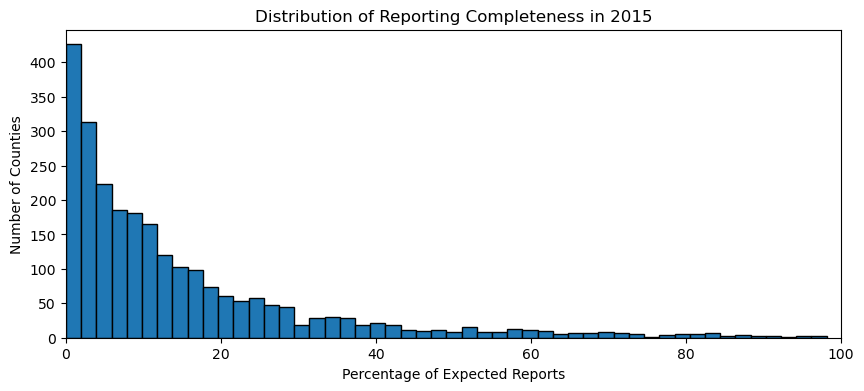

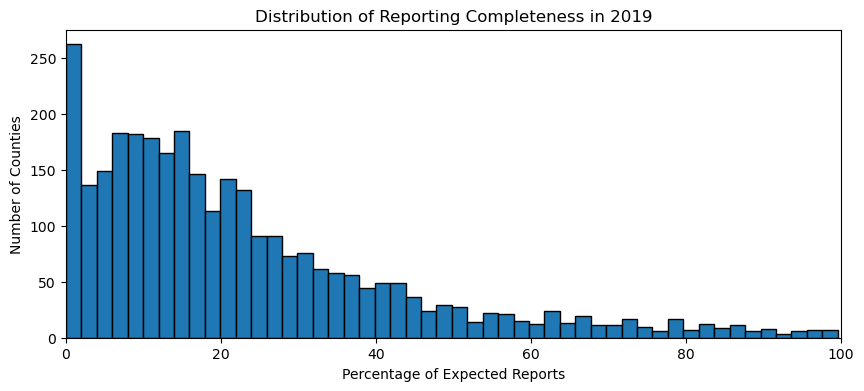

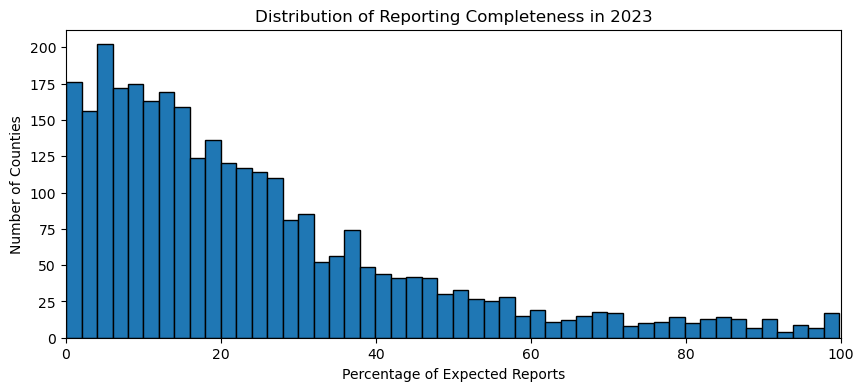

In [7]:
expected_reports = 4 * 24 * 365

plot_reporting_distribution(eaglei_outages_2015, 'run_start_time', expected_reports)
plot_reporting_distribution(eaglei_outages_2019, 'run_start_time', expected_reports)
plot_reporting_distribution(eaglei_outages_2023, 'run_start_time', expected_reports)

Looking at the above summary, we see that a significant number of counties reported less frequently than once every 15 minutes. Since we plan to perform daily aggregation based on the collected weather data (while also considering that the model will have much broader practical applications if it can accurately predict the average number of people losing power in a given day), let's proceed with aggregation by calculating the average and see how this affects the reporting frequency.  

In [6]:
outages_dfs_agg = [aggregate_daily_outages(df) for df in outages_dfs]

In [5]:
outages_dfs_agg[9]

,date,fips_code,county,state,customers_out
0,2023-01-01,1001,Autauga,Alabama,3.827586
1,2023-01-01,1003,Baldwin,Alabama,27.584270
2,2023-01-01,1005,Barbour,Alabama,4.000000
3,2023-01-01,1007,Bibb,Alabama,4.000000
4,2023-01-01,1009,Blount,Alabama,4.000000
...,...,...,...,...,...
870384,2023-12-31,72113,Ponce,Puerto Rico,1710.780000
870385,2023-12-31,72127,San Juan,Puerto Rico,187.687500
870386,2023-12-31,78010,St. Croix,United States Virgin Islands,10.895833
870387,2023-12-31,78020,St. John,United States Virgin Islands,19.266667


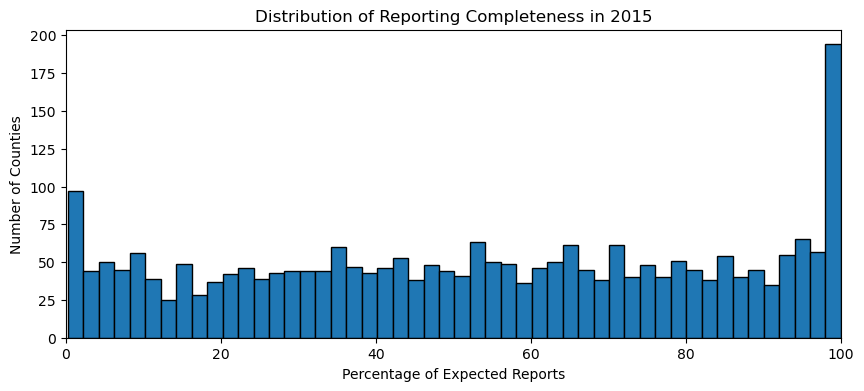

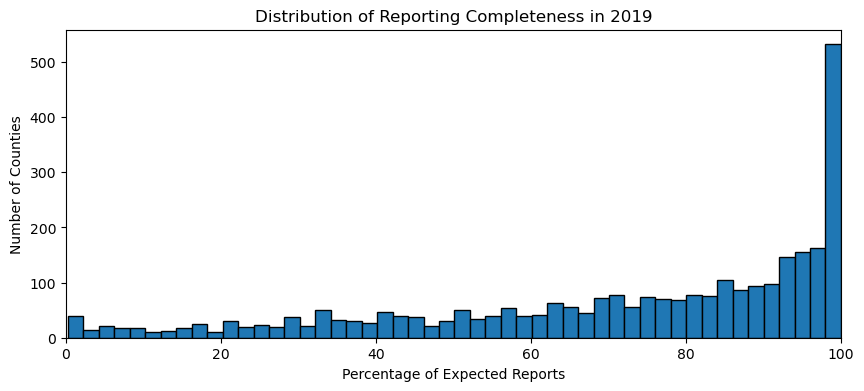

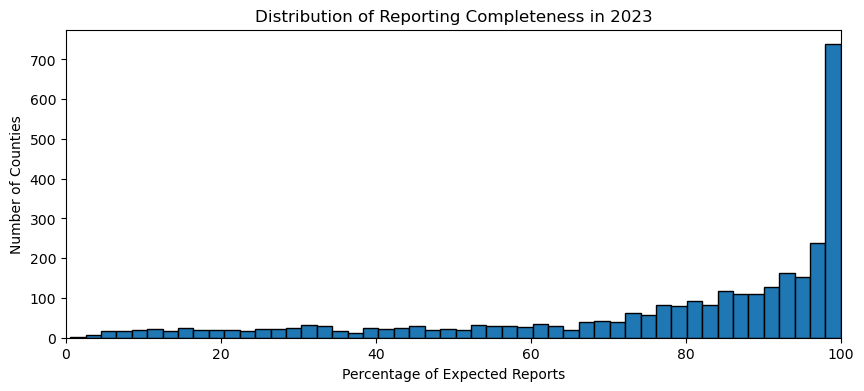

In [10]:
expected_reports = 365

plot_reporting_distribution(outages_dfs_agg[1], 'date', expected_reports)
plot_reporting_distribution(outages_dfs_agg[5], 'date', expected_reports)
plot_reporting_distribution(outages_dfs_agg[9], 'date', expected_reports)

Looking specifically at the final years in the dataset, we observe a striking improvement in data quality. The vast majority of counties report at least once a day. However, there are still some counties that report less frequently than we would expect.  

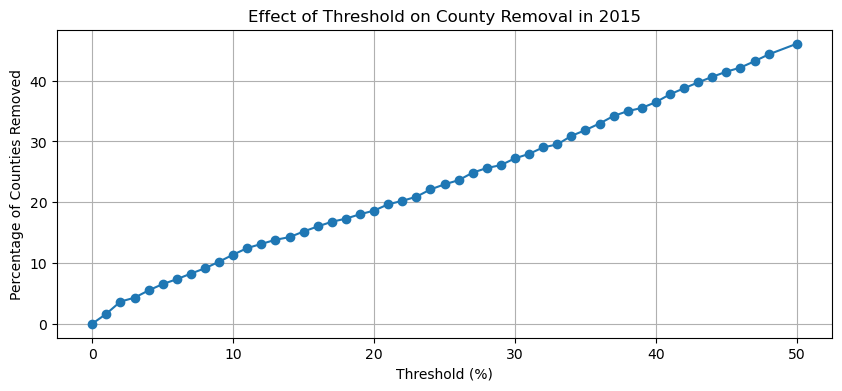

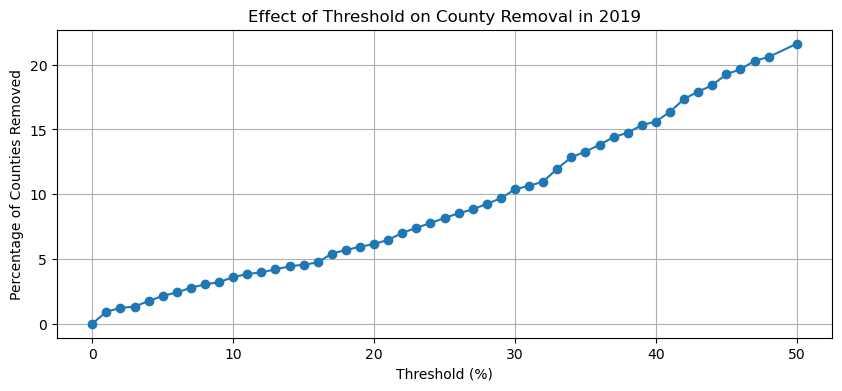

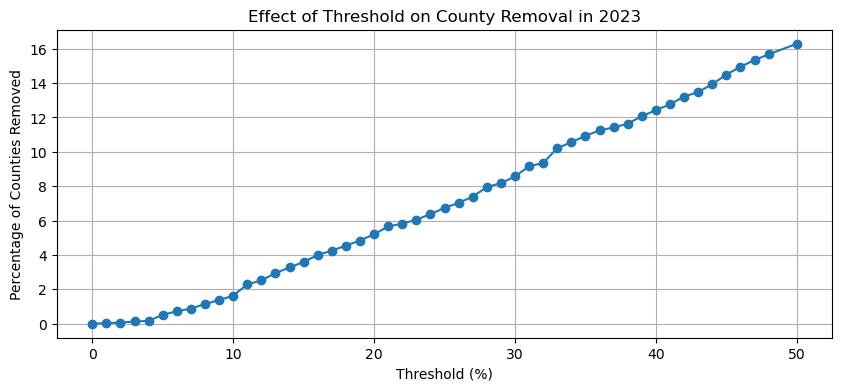

In [11]:
expected_reports = 365
thresholds = np.linspace(0, 50, 50, dtype=int)
plot_removal_effect(outages_dfs_agg[1], 'date', expected_reports, thresholds)
plot_removal_effect(outages_dfs_agg[5], 'date', expected_reports, thresholds)
plot_removal_effect(outages_dfs_agg[9], 'date', expected_reports, thresholds)

After analyzing the data gaps and the number of counties removed in different years, we decide to set the threshold at 30. Counties that reported less frequently in a given year due to their lack of consistency contain low-quality data, and we do not want to include them in the model.

We will exclude data from 2014 as it was only two months and not many counties have had reported then.

In [7]:
outages_dfs_agg.pop(0)

,date,fips_code,county,state,customers_out
0,2014-11-01,1001,Autauga,Alabama,3.000000
1,2014-11-01,1003,Baldwin,Alabama,2.192308
2,2014-11-01,1013,Butler,Alabama,30.611111
3,2014-11-01,1021,Chilton,Alabama,1.000000
4,2014-11-01,1031,Coffee,Alabama,2.000000
...,...,...,...,...,...
70271,2014-12-31,55029,Door,Wisconsin,1.000000
70272,2014-12-31,55079,Milwaukee,Wisconsin,1.000000
70273,2014-12-31,55093,Pierce,Wisconsin,6.000000
70274,2014-12-31,55125,Vilas,Wisconsin,6.000000


In [8]:
expected_reports = 365
outages_dfs_agg_cl = [filter_low_reporting_counties(df, 'date', expected_reports, 30) for df in outages_dfs_agg]

#### U.S. Counties Population and Electricity Access Dataset

We will use new dataset that provides detailed population data by county in the United States. This dataset includes up-to-date information gathered from authoritative sources such as the U.S. Census Bureau and the Bureau of Labor Statistics.

This dataset is based on the freely available data from [SimpleMaps U.S. Counties Dataset](https://simplemaps.com/data/us-counties).

In [9]:
population_data = pd.read_csv('../data/population_data/uscounties.csv')
population_data = population_data[['county_fips', 'population', 'lat', 'lng']]
population_data.loc[:, 'county_fips'] = population_data['county_fips'].astype(str)

Now, we will add an extra column that indicates which data points are more trustworthy—specifically, those with at least 90% completeness over the year. This column will contain a `1` for trustworthy data and a `0` for less complete data.  

Next, we will split the dataset and train a model to determine which approach yields better results. Additionally, we will experiment with different methods for handling missing data. First, we will fill missing values with `0`, assuming that no events occurred during those periods. In the second approach, we will estimate missing values by calculating the mean percentage of people without power in the closest area and multiplying it by the population of each county.  

Finally, we will evaluate which method is more accurate by checking the correlation between the `customers_out` column and events in the StormEvents dataset, as we expect this correlation to be high.

In [10]:
expected_reports = 365
outages_dfs_agg_cl_v1 = [add_valid_data_flag(df, 'date', expected_reports) for df in outages_dfs_agg_cl]

In [11]:
outages_dfs_agg_cl_v2 = [fill_missing_dates(df) for df in outages_dfs_agg_cl_v1]

Based on the provided DataFrame, we create the `percent_customers_out` column (for the few cases where the value of this column exceeds 100%, we replace it with 100).

In [12]:
outages_dfs_agg_cl_v3 = [calculate_percent_customers_out(df, mcc) for df in outages_dfs_agg_cl_v2]

In [13]:
outages_dfs_agg_cl_v4 = [estimate_customers_out(df, mcc) for df in outages_dfs_agg_cl_v3]

Using the population data, we added the 'lat' and 'lng' columns, which contain the geographical coordinates (latitude and longitude) of the counties.

In [14]:
outages_dfs_agg_geo = [addGeo(df, population_data[['county_fips', 'lat', 'lng']]) for df in outages_dfs_agg_cl_v4]

In [15]:
outages_final = combine_dfs(outages_dfs_agg_geo)

In [16]:
outages_final

,fips_code,date,county,state,valid_data_flag,customers_out,percent_customers_out,customers_out_estimate,county_fips,lat,lng
0,1021,2015-01-01,Chilton,Alabama,0,3.000000,0.015453,3.000000,1021,32.8479,-86.7188
1,1021,2015-01-02,Chilton,Alabama,0,13.375000,0.068894,13.375000,1021,32.8479,-86.7188
2,1021,2015-01-03,Chilton,Alabama,0,0.000000,0.000000,3.920775,1021,32.8479,-86.7188
3,1021,2015-01-04,Chilton,Alabama,0,39.333333,0.202603,39.333333,1021,32.8479,-86.7188
4,1021,2015-01-05,Chilton,Alabama,0,0.000000,0.000000,9.191099,1021,32.8479,-86.7188
...,...,...,...,...,...,...,...,...,...,...,...
8058005,47027,2023-12-27,Clay,Tennessee,0,3.000000,0.073983,3.000000,47027,36.5511,-85.5439
8058006,47027,2023-12-28,Clay,Tennessee,0,3.000000,0.073983,3.000000,47027,36.5511,-85.5439
8058007,47027,2023-12-29,Clay,Tennessee,0,0.000000,0.000000,6.475987,47027,36.5511,-85.5439
8058008,47027,2023-12-30,Clay,Tennessee,0,0.000000,0.000000,11.892883,47027,36.5511,-85.5439


In [17]:
outages_final.to_csv('../data/modeling/outages_final.csv', index=False)

#### **Summary of the Final DataFrame**

The final DataFrame represents an aggregation of daily data with the following key columns:

1. **fips_code**: A unique identifier for each county.
2. **date**: The specific date of the record.
3. **county**: The name of the county.
4. **state**: The state to which the county belongs.
5. **valid_data_flag**: A flag indicating the quality of the data, where:
   - **1**: Represents counties reporting data for at least 90% of the days in the year.
   - **0**: Represents counties with less frequent data reporting.
6. **customers_out**: The original column showing the number of customers without power. This value has been supplemented with zeros for records that were missing.
7. **percent_customers_out**: The percentage of customers without power, calculated using data from the `MCC.csv` file.
8. **customers_out_estimate**: This column estimates the `customers_out` for records where the value was zero. The estimate is calculated by taking the average percentage of customers without power in the respective county and multiplying it by the total number of customers in that county.
9. **lat**: The latitude of the county, representing the geographical location, from the 'uscounties.csv' file.
10. **lng**: The longitude of the county, representing the geographical location,from the 'uscounties.csv' file.

It's important to note that this is not the final dataset we will use for modeling. The features selected for modeling will be determined during the later stages of feature engineering. 

This dataset serves as a foundational step in preparing and enriching the data for future analysis and modeling.

__________________________________________________________________________________

## NOAA_StormEvents

When preparing the NOAA Storm Events dataset for modeling, we carefully evaluated each column based on its relevance, interpretability, and potential predictive power.

### Columns Removed and Justification  

When preparing the dataset for analysis and modeling, we decided to remove certain columns that were redundant, had excessive missing values, or lacked predictive value. Below is a summary of our choices and reasoning:  

### Redundant Date & Time Columns  
These columns are unnecessary because we already have a comprehensive timestamp (`BEGIN_DATE_TIME`):  
- **BEGIN_YEARMONTH, BEGIN_DAY, BEGIN_TIME, YEAR, MONTH_NAME** – All information is contained within `BEGIN_DATE_TIME`.  
- **END_YEARMONTH, END_DAY, END_TIME, END_DATE_TIME** – In many cases, they mirror the corresponding "BEGIN" values.  

###  Identifiers with No Predictive Value  
These columns serve as unique identifiers but do not provide useful information for predictions:  
- **EPISODE_ID, EVENT_ID**  

###  Location and Metadata Redundancies  
These columns do not add meaningful information beyond what is already available in latitude, longitude, and other geographical data:  
- **WFO** – A regional code that does not provide direct weather-related insights.  
- **CZ_TIMEZONE** – We already have latitude, longitude, and time information.  
- **BEGIN_LOCATION / END_LOCATION** – We have precise latitude and longitude coordinates, making these redundant.  
- **END_LAT / END_LON** – In 50% cases, these values are identical to `BEGIN_LAT` and `BEGIN_LON`.  

###  Columns with Too Many Missing Values     
These columns have excessive missing values
- **MAGNITUDE / MAGNITUDE_TYPE** – Insufficient data coverage.  
- **FLOOD_CAUSE** 
- **TOR_F_SCALE, TOR_LENGTH, TOR_WIDTH** – Only applicable to tornadoes, and missing for all other event types.  
- **TOR_OTHER_WFO, TOR_OTHER_CZ_STATE, TOR_OTHER_CZ_FIPS, TOR_OTHER_CZ_NAME** 

###  Text-Based Columns (Not Used in Our Approach)  
These columns contain long text narratives, which we are not using since we are not applying NLP models:  
- **EPISODE_NARRATIVE, EVENT_NARRATIVE** 

###  Other Irrelevant Columns  
- **DATA_SOURCE** – Contains only one unique value, providing no useful information.  
- **SOURCE** – Lacks a clear predictive role 

In [5]:
summarize_overall_missing(stormEvents_dfs)

,DATASET,MISSING_MAGNITUDE,PRESENT_MAGNITUDE,MISSING_PERCENT
0,stormEvents_2014,29969,29506,50.39
1,stormEvents_2015,29273,28634,50.55
2,stormEvents_2016,24661,31344,44.03
3,stormEvents_2017,23330,33699,40.91
4,stormEvents_2018,34063,28634,54.33
5,stormEvents_2019,32244,35617,47.51
6,stormEvents_2020,26418,34861,43.11
7,stormEvents_2021,31333,30056,51.04
8,stormEvents_2022,36148,33738,51.72
9,stormEvents_2023,35327,40269,46.73


In [18]:
stormEvents_events_col = [create_event_columns(df) for df in stormEvents_dfs]

% of rows whre BEGIN_LAT = BEGIN_LON

In [13]:
equal_percent = (stormEvents_2015["BEGIN_LON"] == stormEvents_2015["END_LON"]).mean() * 100

print(f"% rows, where BEGIN_LAT = BEGIN_LON: {equal_percent:.2f}%")

% rows, where BEGIN_LAT = BEGIN_LON: 46.17%


% of rows wheree END_AZIMUTH does not have value

In [14]:
missing_percent = stormEvents_2015["END_AZIMUTH"].isna().mean() * 100

print(f"% rows without value in END_AZIMUTH: {missing_percent:.2f}%")

% rows without value in END_AZIMUTH: 35.61%


### New Features  

1. **Category Column**  
   - We will use one-hot encoding to represent different types of catastrophes as separate features.  

2. **Creating New Columns**  
   - **`total_damages`** = `DAMAGE_PROPERTY` + `DAMAGE_CROPS`  
   - **`total_people_injuries`** = `DEATHS_DIRECT` + `DEATHS_INDIRECT` + `INJURIES_DIRECT` + `INJURIES_INDIRECT`  
   - **`percent_of_deaths`** = (`DEATHS_DIRECT` + `DEATHS_INDIRECT`) / `total_people_injuries`  

Columns MAGNITUDE, CATEGORY, and TOR_F_SCALE represent event intensity. 

To unify this data into a single MAGNITUDE column, we first convert TOR_F_SCALE (tornado intensity) into numerical values, handling unknown EFU values by replacing them with state-based medians. 

Missing MAGNITUDE values are then filled using CATEGORY and, if necessary, TOR_F_SCALE.

We implemented a similar approach to one-hot encoding: for events without intensity data, we use one-hot encoding (assigning a 1 for the corresponding event). For events with intensity data, we replace the 1 in the event's column with the value from the MAGNITUDE column.

In [19]:
stormEvents_events_col = [create_event_columns(df) for df in stormEvents_dfs]

Columns DAMAGE_PROPERTY and DAMAGE_CROPS first have to be transformed into floats then they are used to create new column total_damages.
From other damege columns we create: columns total_people_injuries and percent_of_deaths

In [20]:
stormEvents_damages = [convert_damage_property(df) for df in stormEvents_events_col]

In [21]:
stormEvents_new_col = [process_storm_events(df) for df in stormEvents_events_col]

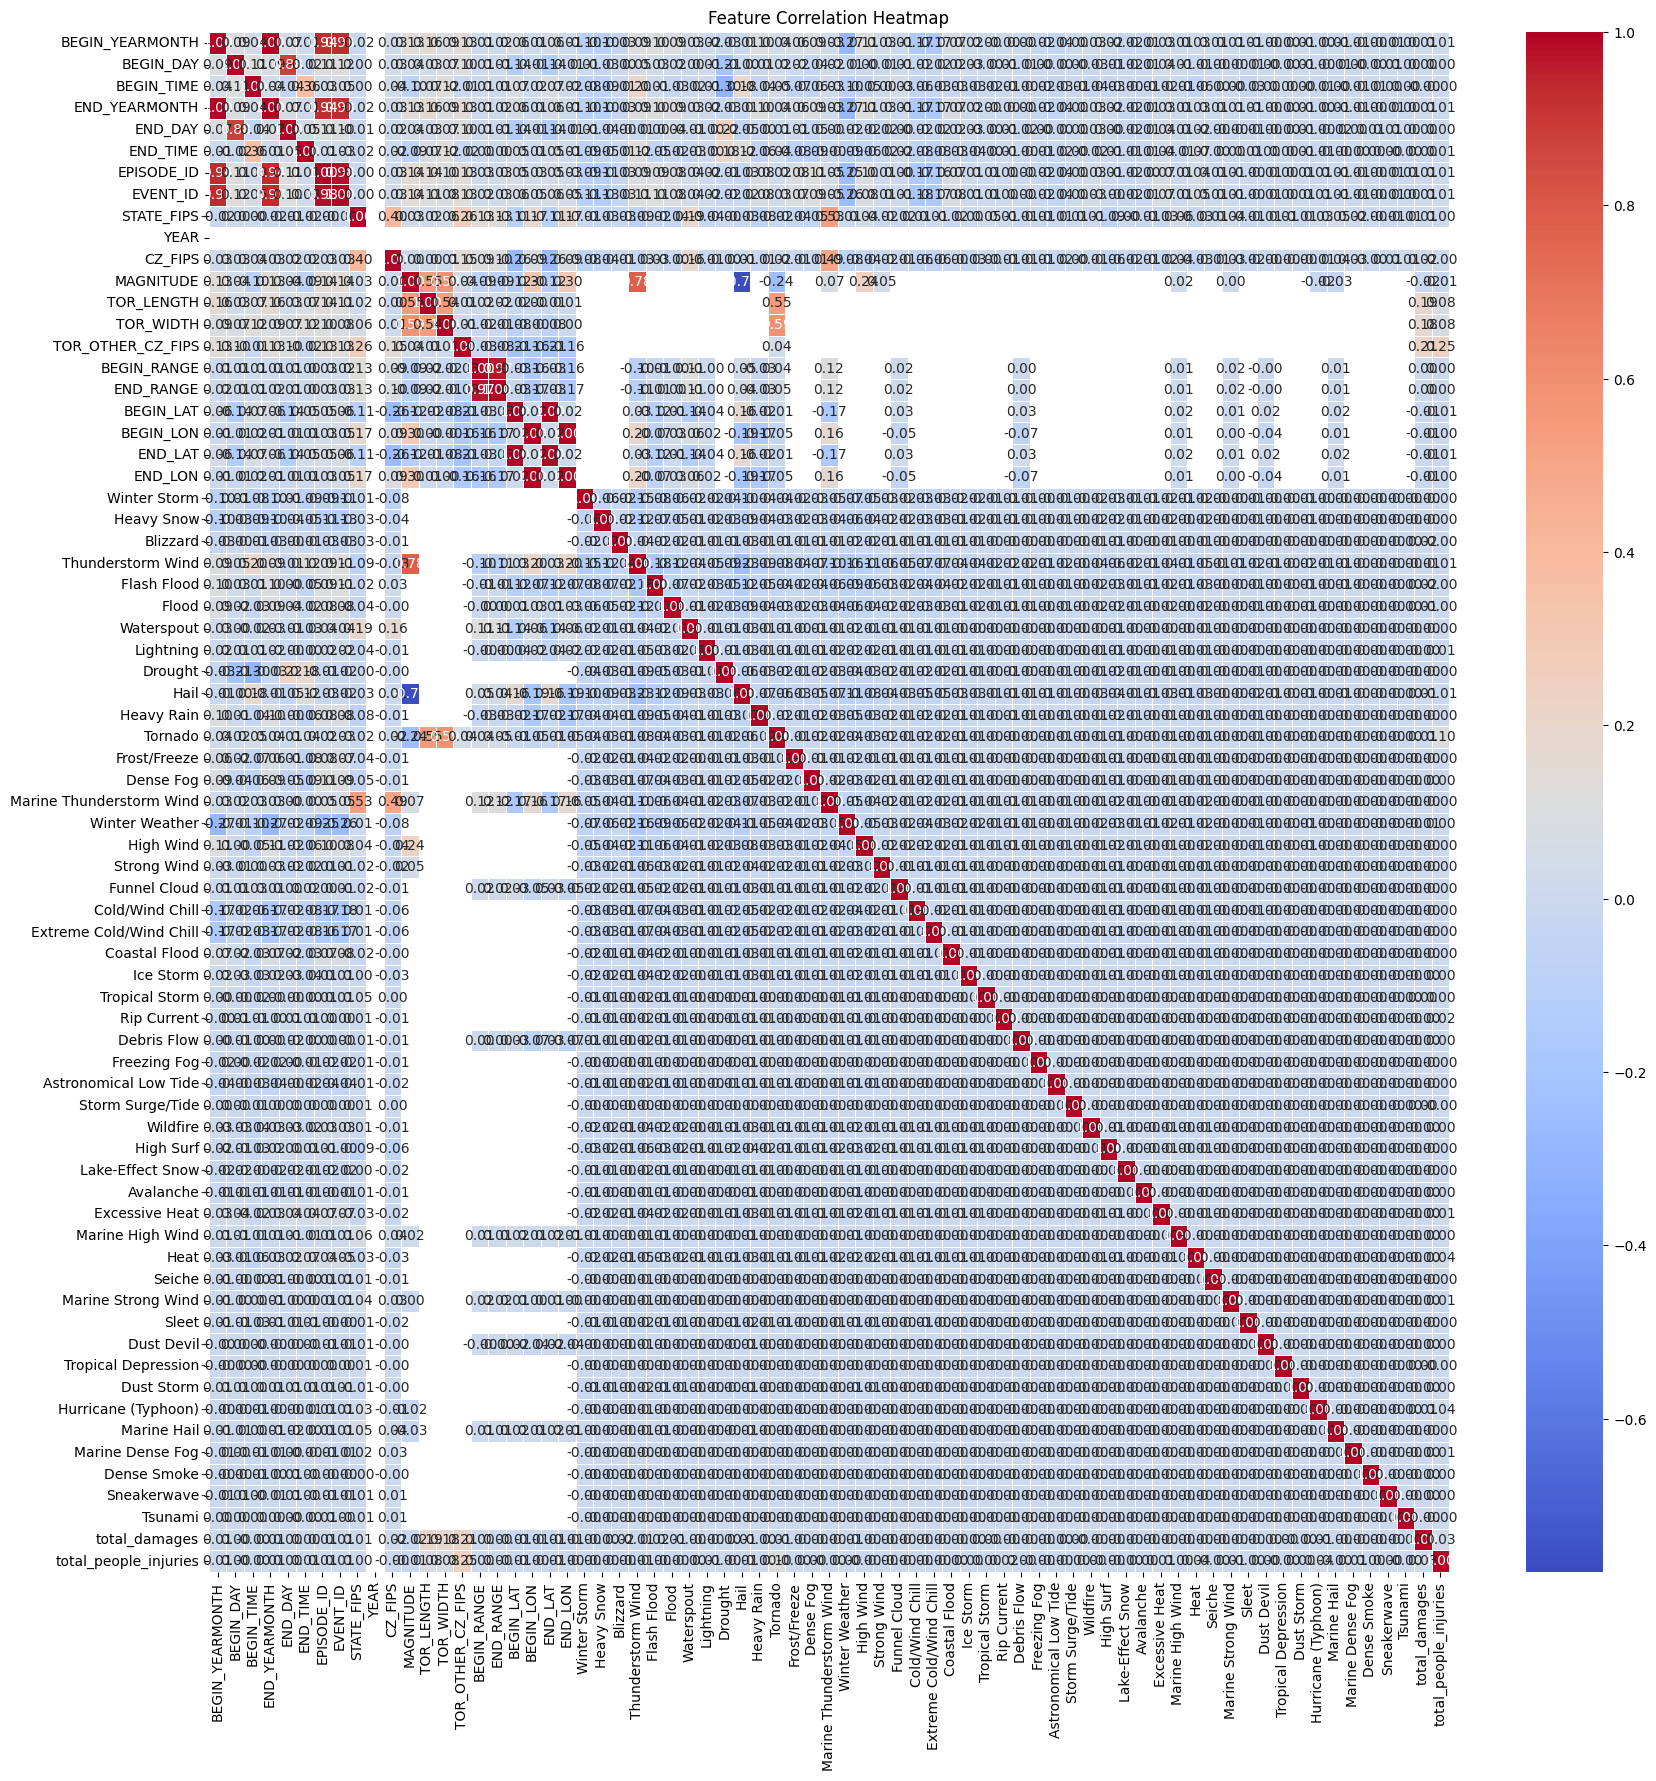

In [22]:
numeric_cols = stormEvents_new_col[1].select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
